In [8]:
'''Custom ADRIO example with the daily total hospitalizations dataset'''

'Custom ADRIO example with the daily total hospitalizations dataset'

In [9]:
from epymorph.kit import *
from epymorph.adrio import cdc
import numpy as np
import matplotlib.pyplot as plt
from epymorph.adrio import acs5

from epymorph.adrio import us_tiger

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.forecasting.likelihood import Poisson
from epymorph.forecasting.dynamic_params import OrnsteinUhlenbeck
from epymorph.forecasting.dynamic_params import GaussianPrior
from epymorph.forecasting.param_transformations import ExponentialTransform

from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.time import EveryNDays
from epymorph.forecasting.likelihood import NegativeBinomial

cdcadrio_H = cdc.InfluenzaStateHospitalizationDaily(
    column = 'hospitalizations',
    fix_missing=0
)

In [10]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *

class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low = 0, high = self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

In [11]:
states = ["AZ","NV","MA"]

rume = SingleStrataRUME.build(
    ipm=ipm.SIRH(),
    mm=mm.No(),
    scope=StateScope.in_states(states,year=2019),
    init=RandomLocationsAndRandomSeed(
        num_locations=len(states),
        seed_max=10_000
    ),
    time_frame=TimeFrame.range("2020-10-24", "2024-04-27"),
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.2,
        "xi": 1 / 365,
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
        "centroid": us_tiger.InternalPoint(),
    },
)

In [12]:
observations_H = Observations(
    source=cdcadrio_H,
    model_link=ModelLink(
        quantity=rume.ipm.select.compartments("H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(), #Changed from 1 day to 7 days
        geo=rume.scope.select.all(),
    ),
    likelihood=NegativeBinomial(r=10), #Changed to a negative binomial likelihood
)

In [13]:
num_realizations = 5
rng = np.random.default_rng(1)

unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=1/35,
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
    )
}

particle_filter_simulator_H = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations_H,
        save_trajectories=True,
    )


In [14]:
particle_filter_output_H = particle_filter_simulator_H.run(rng=rng)

ADRIOCommunicationError: Error loading epymorph.adrio.cdc.InfluenzaStateHospitalizationDaily: the ADRIO was unable to communicate with the external resource

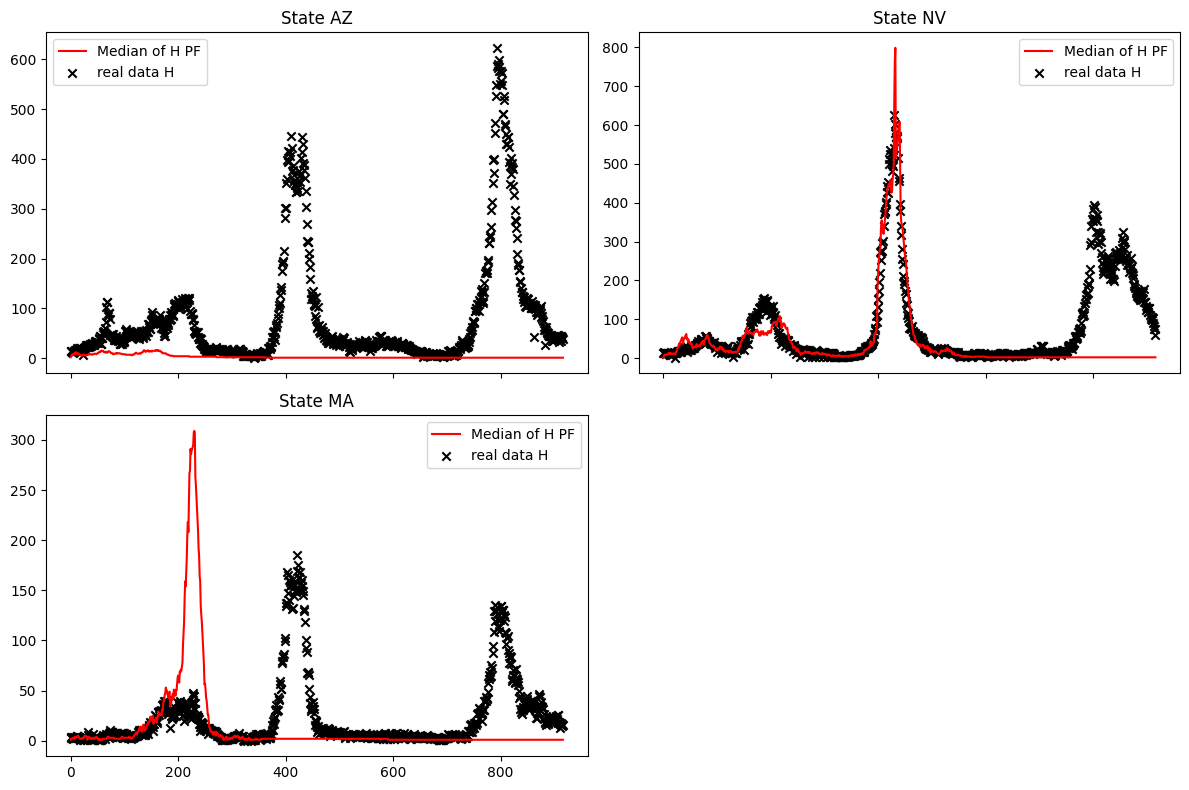

In [ ]:
from epymorph.simulation import Context,NamePattern
from math import ceil

context = Context.of(
    scope=rume.scope,
    time_frame=rume.time_frame
)

real_data_result = (
    observations_H.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(0,rume.time_frame.days,1)


n = len(states)
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()


for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    median_H  = np.median(particle_filter_output_H.posterior_values[:,:,i,0], axis=1).squeeze()

    ax.plot(data_date_range, median_H, color='red', label='Median of H PF')
    ax.scatter(data_date_range,real_data[:,i],marker = 'x',color = 'black',label = 'real data H')
    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()